In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [2]:
df = pd.read_csv("Sample-Superstore.csv", encoding='windows-1252')


In [3]:
df["Order Date"] = pd.to_datetime(df["Order Date"])


In [4]:
df["Ship Date"] = pd.to_datetime(df["Ship Date"])


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Row ID         9994 non-null   int64          
 1   Order ID       9994 non-null   object         
 2   Order Date     9994 non-null   datetime64[ns] 
 3   Ship Date      9994 non-null   datetime64[ns] 
 4   Ship Mode      9994 non-null   object         
 5   Customer ID    9994 non-null   object         
 6   Customer Name  9994 non-null   object         
 7   Segment        9994 non-null   object         
 8   Country        9994 non-null   object         
 9   City           9994 non-null   object         
 10  State          9994 non-null   object         
 11  Postal Code    9994 non-null   int64          
 12  Region         9994 non-null   object         
 13  Product ID     9994 non-null   object         
 14  Category       9994 non-null   object         
 15  Sub-

In [5]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [6]:
df[df["Customer ID"] == "CG-12520"][["Customer Name", "Customer ID", "State"]]


,Customer Name,Customer ID,State
0,Claire Gute,CG-12520,Kentucky
1,Claire Gute,CG-12520,Kentucky
5491,Claire Gute,CG-12520,Texas
6877,Claire Gute,CG-12520,Texas
6878,Claire Gute,CG-12520,Texas


In [7]:
p_customer_id = df.groupby("Customer ID").agg(
    {'State': 'last'})
p_customer_id


,State
Customer ID,
AA-10315,New York
AA-10375,Rhode Island
AA-10480,Michigan
AA-10645,Oklahoma
AB-10015,Oklahoma
...,...
XP-21865,Florida
YC-21895,Nebraska
YS-21880,California


In [8]:
s_customer_id = df.groupby("Customer ID").agg(
    {'Segment': 'last'})
s_customer_id


,Segment
Customer ID,
AA-10315,Consumer
AA-10375,Consumer
AA-10480,Consumer
AA-10645,Consumer
AB-10015,Consumer
...,...
XP-21865,Consumer
YC-21895,Corporate
YS-21880,Corporate


In [9]:

p_customer_id[p_customer_id.index == "CG-12520"]


,State
Customer ID,
CG-12520,Texas


In [10]:
# New Attribute : Monetary

df_monetary = df.groupby('Customer ID')['Sales'].sum()
df_monetary = df_monetary.reset_index()
df_monetary.head()


,Customer ID,Sales
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [11]:
df_frequency = df.groupby('Customer ID')['Order ID'].count()
df_frequency = df_frequency.reset_index()
df_frequency.columns = ['Customer ID', 'Frequency']
df_frequency.head()


,Customer ID,Frequency
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6


In [12]:
# Merging the two dfs

m_f_df = pd.merge(df_monetary, df_frequency, on='Customer ID', how='inner')
m_f_df.head()


,Customer ID,Sales,Frequency
0,AA-10315,5563.560,11
1,AA-10375,1056.390,15
2,AA-10480,1790.512,12
3,AA-10645,5086.935,18
4,AB-10015,886.156,6


In [13]:
# New Attribute : Recency

# Compute the maximum date to know the last transaction date

max_date = max(df['Order Date'])
max_date


Timestamp('2017-12-30 00:00:00')

In [14]:
# Compute the difference between max date and transaction date

df['Diff'] = max_date - df['Order Date']
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Diff
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,417 days
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,417 days
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,566 days
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,811 days
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,811 days


In [15]:
# Compute last transaction date to get the recency of customers

r_df = df.groupby('Customer ID')['Diff'].min()
r_df = r_df.reset_index()
r_df.head()


,Customer ID,Diff
0,AA-10315,184 days
1,AA-10375,19 days
2,AA-10480,259 days
3,AA-10645,55 days
4,AB-10015,415 days


In [16]:
# Extract number of days only

r_df['Diff'] = r_df['Diff'].dt.days
r_df.head()


,Customer ID,Diff
0,AA-10315,184
1,AA-10375,19
2,AA-10480,259
3,AA-10645,55
4,AB-10015,415


In [17]:
# Merge tha dataframes to get the final RFM dataframe

final_df = pd.merge(m_f_df, r_df, on='Customer ID', how='inner')
final_df.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency']
final_df.head()


,Customer ID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


Text(0.5, 0, 'Attributes')

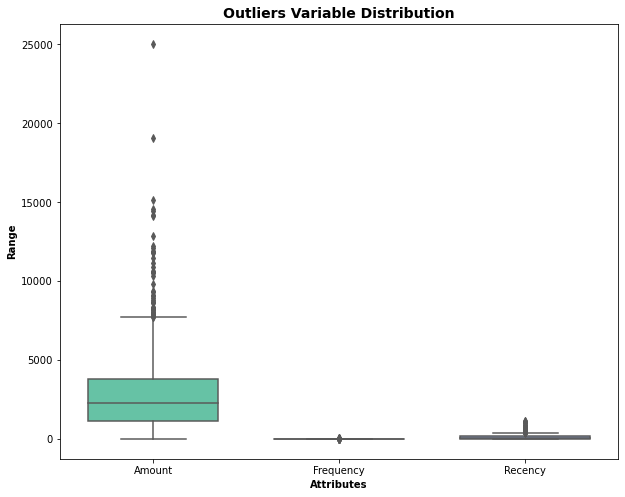

In [18]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=final_df[attributes], orient="v",
            palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')


In [19]:
# Removing (statistical) outliers for Amount
Q1 = final_df.Amount.quantile(0.05)
Q3 = final_df.Amount.quantile(0.95)
IQR = Q3 - Q1
final_df = final_df[(final_df.Amount >= Q1 - 1.5*IQR) & (final_df.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = final_df.Recency.quantile(0.05)
Q3 = final_df.Recency.quantile(0.95)
IQR = Q3 - Q1
final_df = final_df[(final_df.Recency >= Q1 - 1.5*IQR) & (final_df.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = final_df.Frequency.quantile(0.05)
Q3 = final_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
final_df = final_df[(final_df.Frequency >= Q1 - 1.5*IQR) & (final_df.Frequency <= Q3 + 1.5*IQR)]


In [20]:
# Rescaling the attributes

final_df_for_cluster = final_df[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
final_df_scaled = scaler.fit_transform(final_df_for_cluster)
final_df_scaled.shape
(4293, 3)
final_df_scaled = pd.DataFrame(final_df_scaled)
final_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
final_df_scaled.head()


,Amount,Frequency,Recency
0,1.074448,-0.256289,0.199319
1,-0.722697,0.384534,-0.686846
2,-0.429981,-0.096083,0.602122
3,0.884404,0.865151,-0.493501
4,-0.790575,-1.057317,1.439951


In [21]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(final_df_scaled)


KMeans(max_iter=50, n_clusters=4)

In [22]:
kmeans.labels_


array([3, 1, 1, 3, 2, 0, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 2, 3, 1, 1, 1,
       3, 2, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 0, 3, 3, 3, 1, 1, 1, 3, 2, 3,
       3, 1, 1, 1, 3, 2, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 0,
       3, 3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1,
       0, 3, 0, 1, 0, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 0, 3, 1, 2, 3, 1,
       2, 1, 2, 2, 1, 3, 2, 1, 3, 1, 1, 2, 3, 1, 3, 0, 1, 3, 2, 1, 3, 0,
       3, 1, 1, 1, 3, 2, 1, 1, 1, 2, 1, 2, 2, 2, 0, 3, 1, 3, 1, 1, 0, 1,
       1, 2, 1, 1, 1, 2, 0, 2, 3, 2, 3, 3, 1, 2, 1, 1, 1, 1, 3, 2, 1, 3,
       3, 3, 1, 2, 3, 3, 1, 3, 1, 1, 2, 2, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1,
       1, 3, 1, 1, 2, 2, 1, 3, 2, 2, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3,
       1, 3, 1, 0, 3, 2, 1, 1, 1, 3, 3, 2, 3, 0, 0, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 2, 1, 3, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 0, 2, 1, 3, 3, 3, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 1, 2,

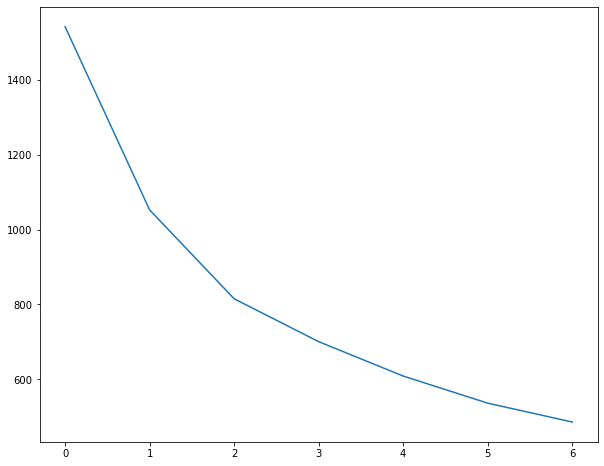

In [23]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(final_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)


In [24]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(final_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(final_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(
        num_clusters, silhouette_avg))


For n_clusters=2, the silhouette score is 0.34796289268710395
For n_clusters=3, the silhouette score is 0.3857252699854754
For n_clusters=4, the silhouette score is 0.3577227976806997
For n_clusters=5, the silhouette score is 0.32740218891629713
For n_clusters=6, the silhouette score is 0.32185675405229214
For n_clusters=7, the silhouette score is 0.33138904972440425
For n_clusters=8, the silhouette score is 0.2905854588307033


In [25]:
# Final model with k=3
kmeans_1 = KMeans(n_clusters=3, max_iter=50)
kmeans_1.fit(final_df_scaled)


KMeans(max_iter=50, n_clusters=3)

In [26]:
kmeans_1.labels_


array([1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2,
       1, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2,
       1, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2,
       0, 2, 0, 0, 2, 1, 0, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1,
       1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 1, 1, 2, 1, 2, 2, 1, 2,
       2, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 2, 2, 2, 2, 1, 0, 2, 1,
       1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 1, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 2, 0,

In [27]:
# assign the label
final_df['Cluster_Id'] = kmeans_1.labels_
final_df.head()


,Customer ID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,5563.560,11,184,1
1,AA-10375,1056.390,15,19,2
2,AA-10480,1790.512,12,259,2
3,AA-10645,5086.935,18,55,1
4,AB-10015,886.156,6,415,0


In [28]:

final_df = pd.merge(final_df, p_customer_id, on='Customer ID', how='inner')
final_df.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency', "Cluster_Id", "State"]
final_df.head()


,Customer ID,Amount,Frequency,Recency,Cluster_Id,State
0,AA-10315,5563.560,11,184,1,New York
1,AA-10375,1056.390,15,19,2,Rhode Island
2,AA-10480,1790.512,12,259,2,Michigan
3,AA-10645,5086.935,18,55,1,Oklahoma
4,AB-10015,886.156,6,415,0,Oklahoma


In [29]:
final_df = pd.merge(final_df, s_customer_id, on='Customer ID', how='inner')
final_df.columns = ['Customer ID', 'Amount',
                    'Frequency', 'Recency', "Cluster_Id", "State", "Segment"]
final_df.head()


,Customer ID,Amount,Frequency,Recency,Cluster_Id,State,Segment
0,AA-10315,5563.560,11,184,1,New York,Consumer
1,AA-10375,1056.390,15,19,2,Rhode Island,Consumer
2,AA-10480,1790.512,12,259,2,Michigan,Consumer
3,AA-10645,5086.935,18,55,1,Oklahoma,Consumer
4,AB-10015,886.156,6,415,0,Oklahoma,Consumer


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

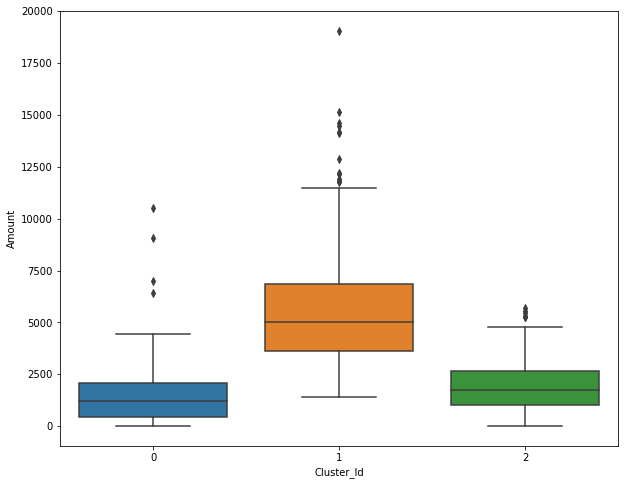

In [91]:
sns.boxplot(data=final_df, x="Cluster_Id", y="Amount")


<AxesSubplot:xlabel='Cluster_Id', ylabel='count'>

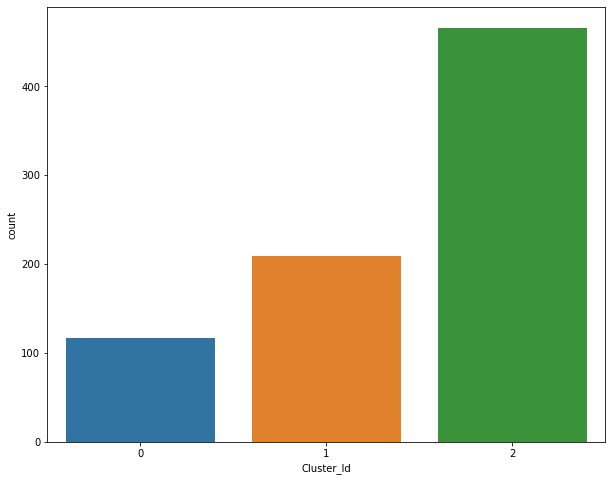

In [30]:
sns.countplot(data=final_df, x="Cluster_Id")

<AxesSubplot:xlabel='Cluster_Id', ylabel='count'>

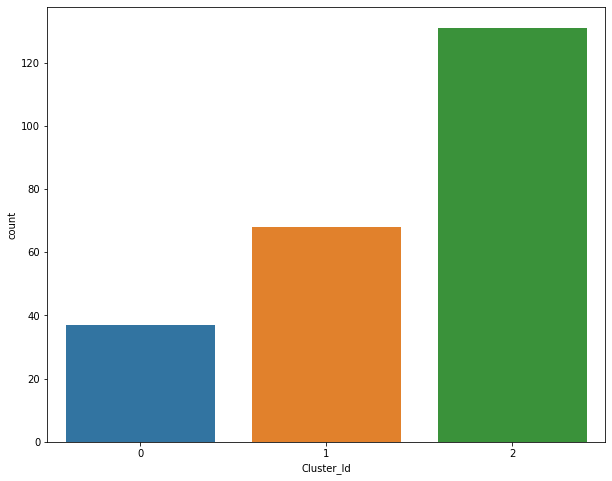

In [31]:
sns.countplot(data=final_df[final_df["Segment"] == "Corporate"], x="Cluster_Id")


<AxesSubplot:xlabel='Cluster_Id', ylabel='count'>

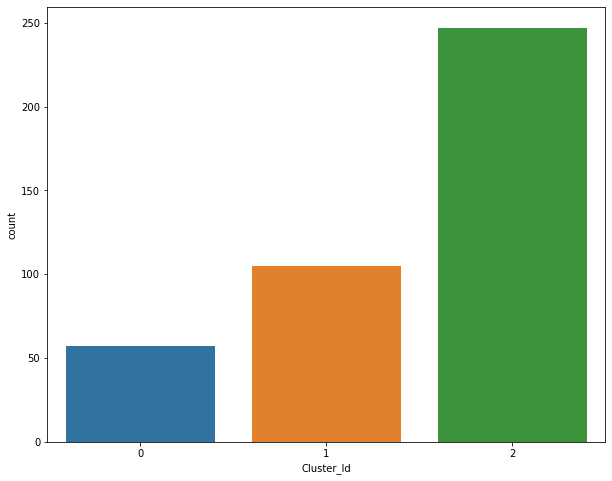

In [32]:
sns.countplot(data=final_df[final_df["Segment"]
              == "Consumer"], x="Cluster_Id")


In [33]:
final_df["State"].value_counts()


California        172
Texas              80
New York           79
Ohio               44
Illinois           42
Pennsylvania       40
Washington         38
Florida            30
North Carolina     25
Virginia           24
Arizona            18
Michigan           17
Indiana            17
Georgia            15
Tennessee          14
Colorado           13
New Jersey         12
Massachusetts      10
Kentucky           10
Delaware            9
Oregon              7
Maryland            7
Oklahoma            7
Minnesota           6
Connecticut         6
Wisconsin           5
Nebraska            5
Missouri            4
Vermont             4
Louisiana           4
Arkansas            3
New Hampshire       3
Idaho               3
New Mexico          3
Alabama             3
Nevada              3
Iowa                2
South Dakota        2
Rhode Island        2
Utah                1
Kansas              1
South Carolina      1
Mississippi         1
Name: State, dtype: int64

<AxesSubplot:xlabel='Cluster_Id', ylabel='count'>

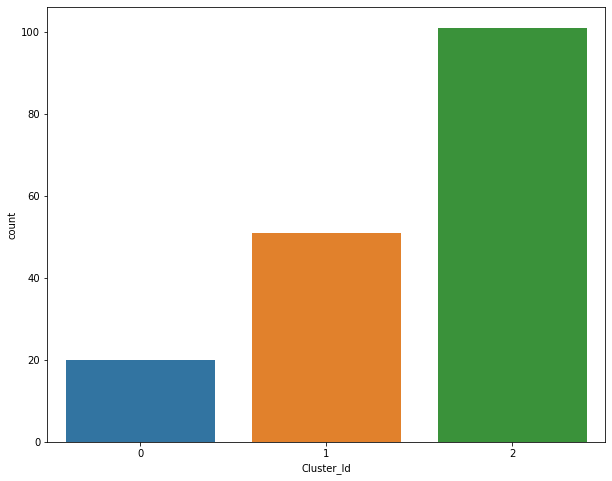

In [34]:
sns.countplot(data=final_df[final_df["State"] == "California"], x="Cluster_Id")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

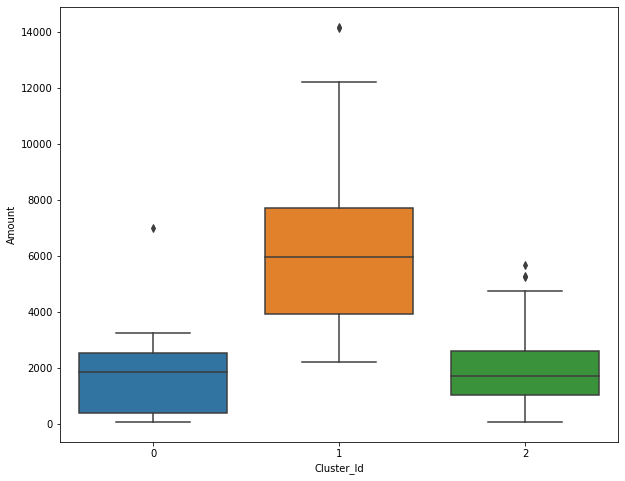

In [98]:
sns.boxplot(data=final_df[final_df["State"] == "California"], x="Cluster_Id", y="Amount")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

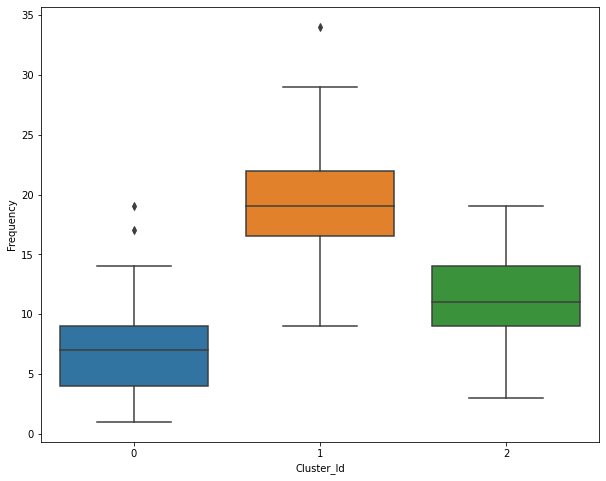

In [100]:
sns.boxplot(data=final_df[final_df["State"] ==
            "California"], x="Cluster_Id", y="Frequency")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

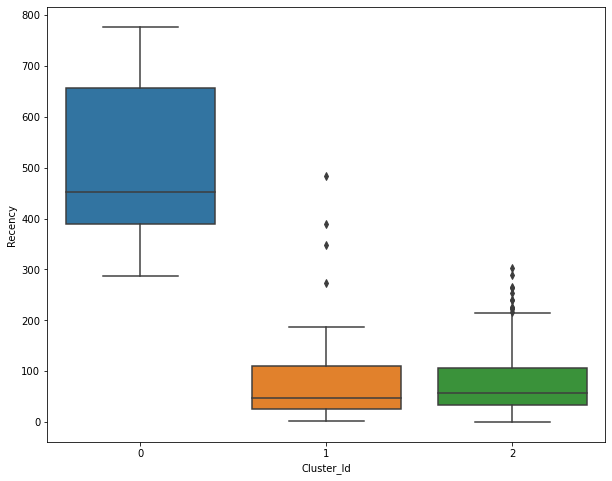

In [102]:
sns.boxplot(data=final_df[final_df["State"] ==
            "California"], x="Cluster_Id", y="Recency")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

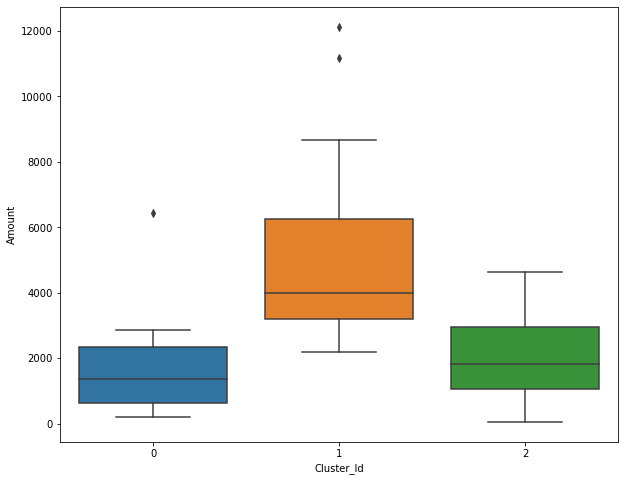

In [99]:
sns.boxplot(data=final_df[final_df["State"] ==
            "Texas"], x="Cluster_Id", y="Amount")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

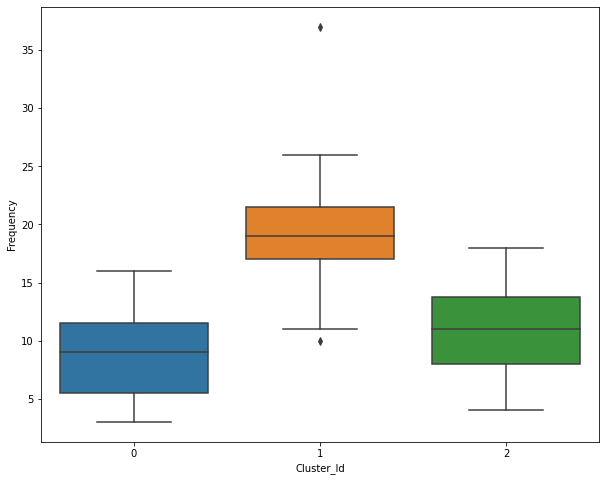

In [101]:
sns.boxplot(data=final_df[final_df["State"] ==
            "Texas"], x="Cluster_Id", y="Frequency")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

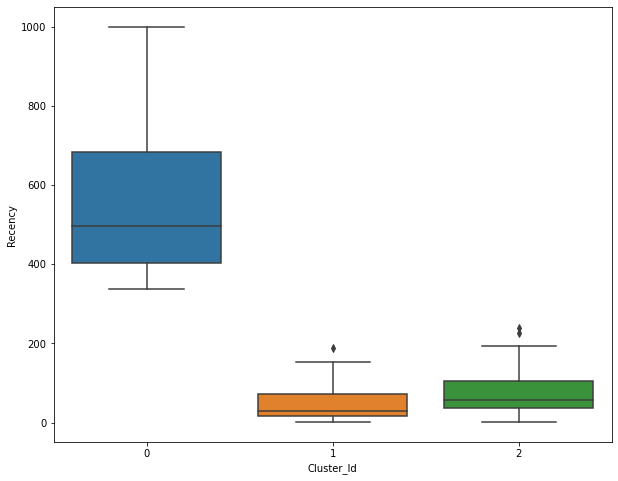

In [103]:
sns.boxplot(data=final_df[final_df["State"] ==
            "Texas"], x="Cluster_Id", y="Recency")


<AxesSubplot:xlabel='Cluster_Id', ylabel='count'>

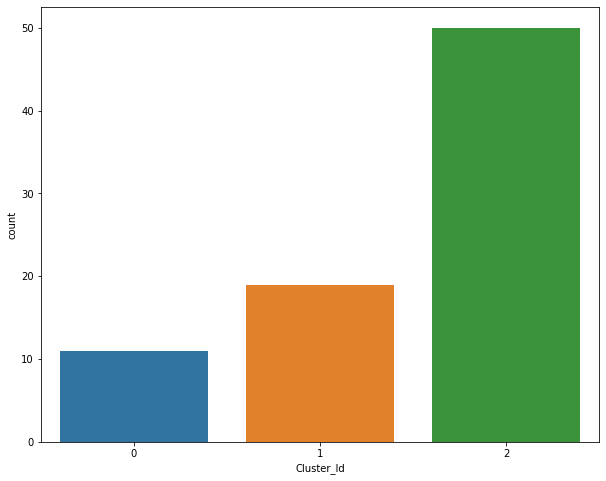

In [35]:
sns.countplot(data=final_df[final_df["State"] == "Texas"], x="Cluster_Id")


<AxesSubplot:xlabel='Cluster_Id', ylabel='count'>

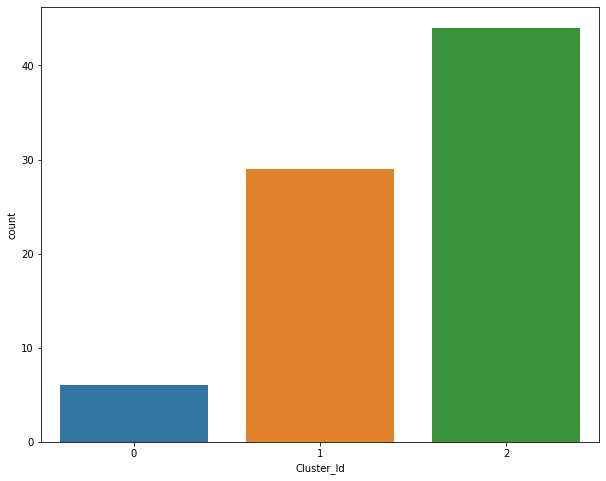

In [36]:
sns.countplot(data=final_df[final_df["State"] == "New York"], x="Cluster_Id")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

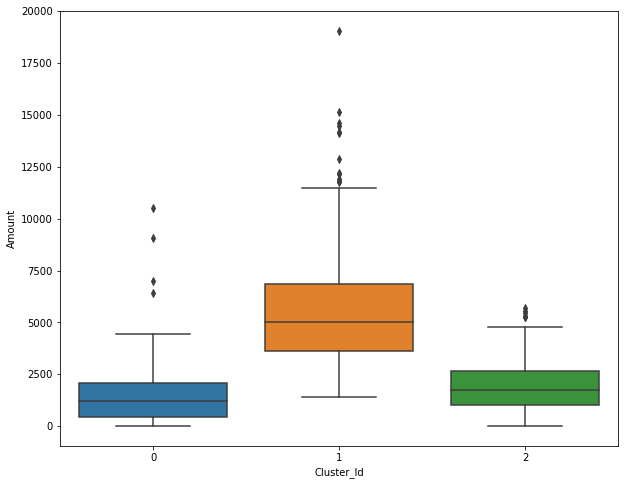

In [37]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=final_df)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

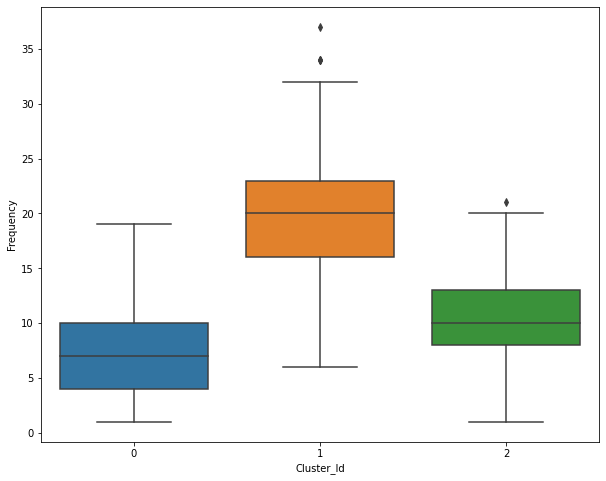

In [38]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=final_df)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

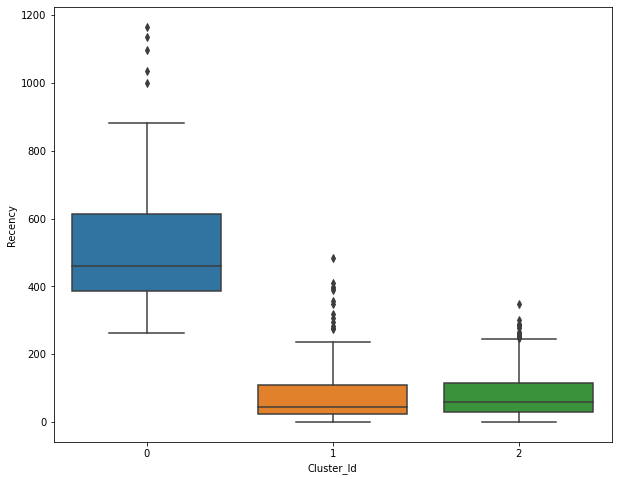

In [39]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=final_df)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

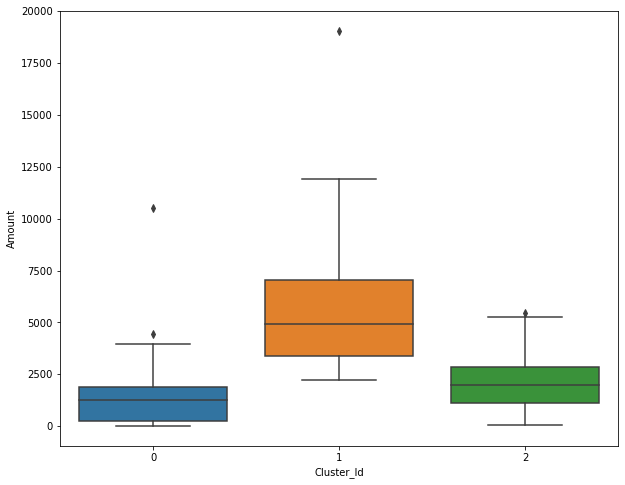

In [92]:
sns.boxplot(x='Cluster_Id', y='Amount', data=final_df[final_df["Segment"] == "Corporate"])


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

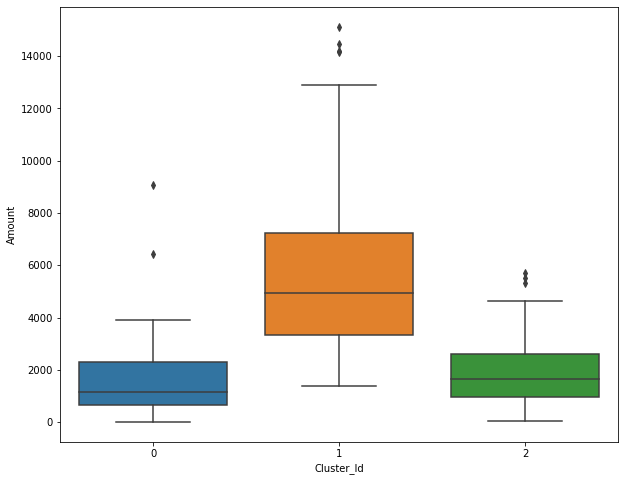

In [93]:
sns.boxplot(x='Cluster_Id', y='Amount',
            data=final_df[final_df["Segment"] == "Consumer"])


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

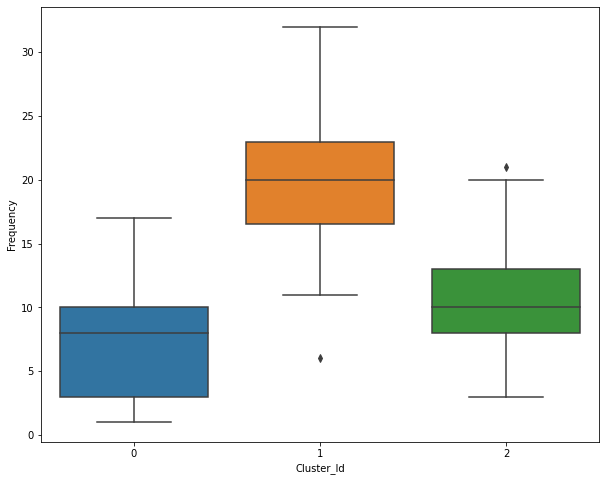

In [94]:
sns.boxplot(x='Cluster_Id', y='Frequency',
            data=final_df[final_df["Segment"] == "Corporate"])


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

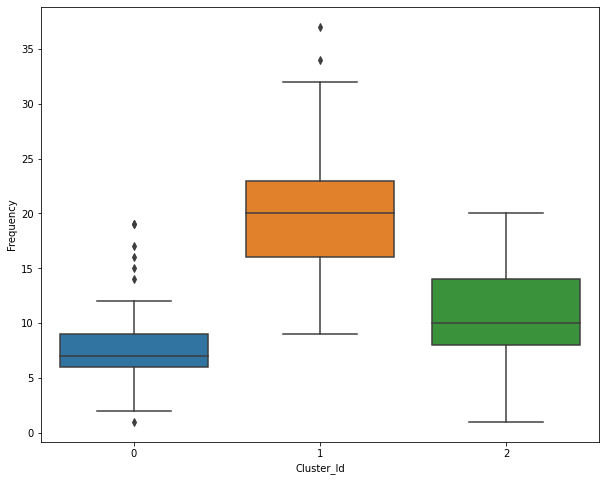

In [95]:
sns.boxplot(x='Cluster_Id', y='Frequency',
            data=final_df[final_df["Segment"] == "Consumer"])


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

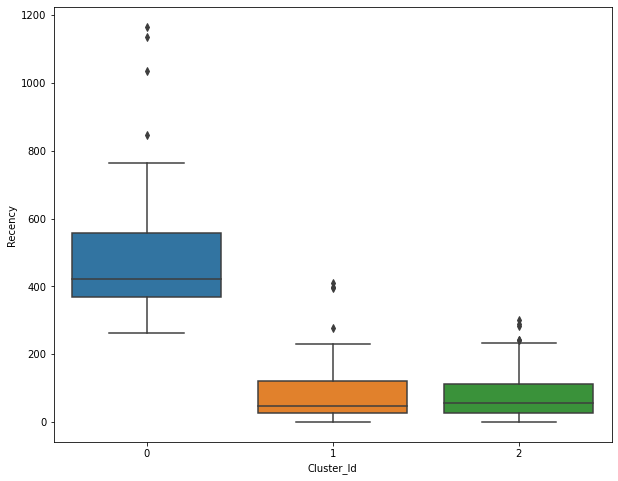

In [96]:
sns.boxplot(x='Cluster_Id', y='Recency',
            data=final_df[final_df["Segment"] == "Corporate"])


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

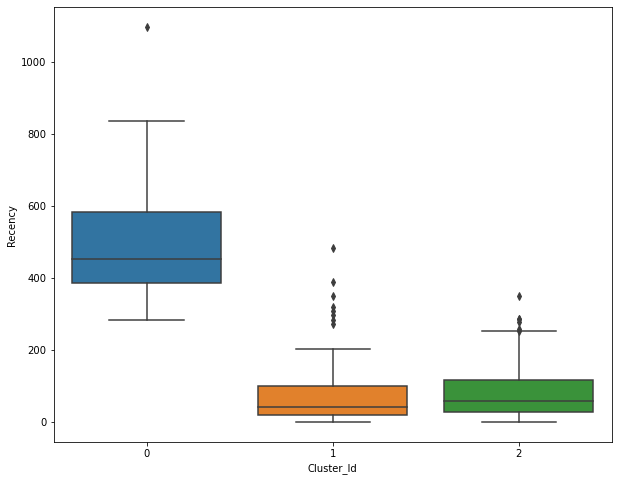

In [97]:
sns.boxplot(x='Cluster_Id', y='Recency',
            data=final_df[final_df["Segment"] == "Consumer"])


In [40]:
# Single linkage:

# mergings = linkage(final_df_scaled, method="single", metric='euclidean')
# dendrogram(mergings)
# plt.show()


In [41]:
# Complete linkage

# mergings = linkage(final_df_scaled, method="complete", metric='euclidean')
# dendrogram(mergings)
# plt.show()


In [42]:
# Average linkage

# mergings = linkage(final_df_scaled, method="average", metric='euclidean')
# dendrogram(mergings)
# plt.show()


In [43]:
# 3 clusters
# cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
# cluster_labels


In [44]:
# Assign cluster labels

# final_df['Cluster_Labels'] = cluster_labels
# final_df.head()


In [45]:
# Plot Cluster Id vs Amount

# sns.boxplot(x='Cluster_Labels', y='Amount', data=final_df)


In [46]:
# Plot Cluster Id vs Frequency

# sns.boxplot(x='Cluster_Labels', y='Frequency', data=final_df)


In [47]:
# Plot Cluster Id vs Recency

# sns.boxplot(x='Cluster_Labels', y='Recency', data=final_df)


<AxesSubplot:xlabel='Amount', ylabel='Frequency'>

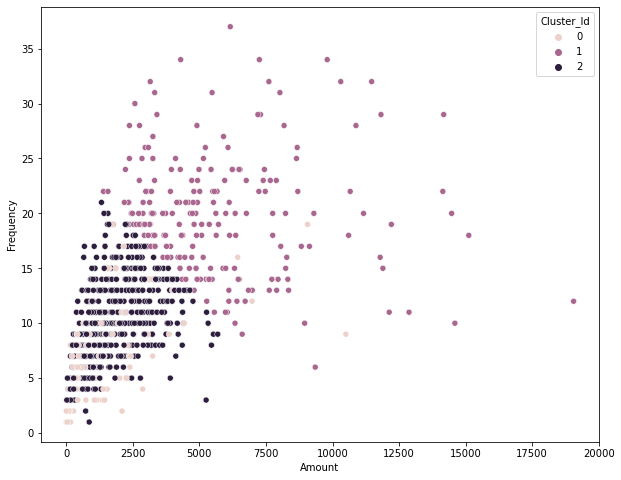

In [48]:
sns.scatterplot(data=final_df, x="Amount", y="Frequency", hue="Cluster_Id")


<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

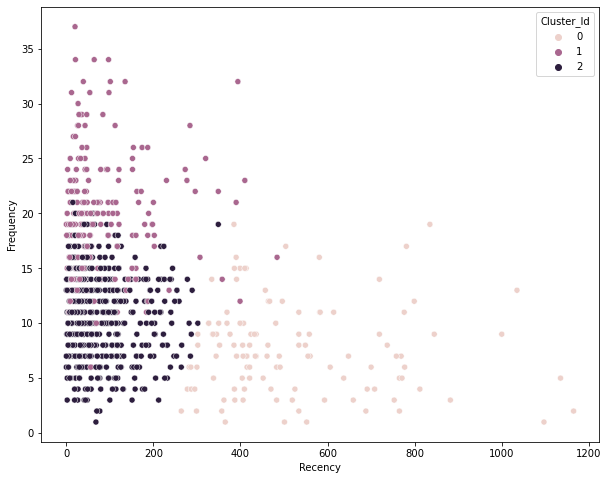

In [49]:
sns.scatterplot(data=final_df, x="Recency", y="Frequency",  hue="Cluster_Id")


<AxesSubplot:xlabel='Recency', ylabel='Amount'>

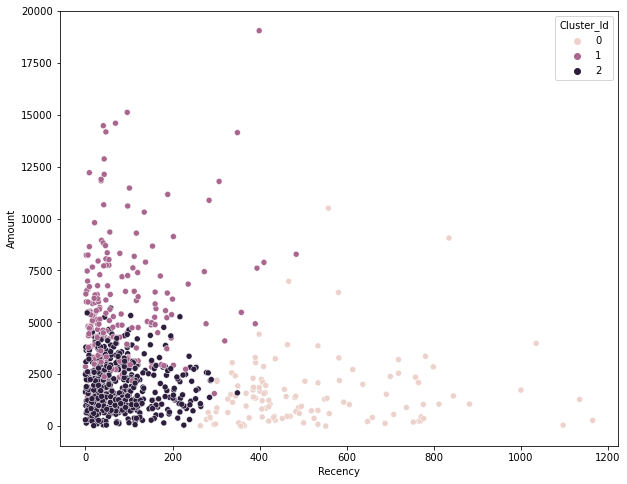

In [50]:
sns.scatterplot(data=final_df, x="Recency", y="Amount",  hue="Cluster_Id")


In [51]:
# sns.scatterplot(data=final_df, x="Amount", y="Frequency", hue="Cluster_Labels")


In [52]:
# sns.scatterplot(data=final_df, x="Recency", y="Frequency",  hue="Cluster_Labels")


In [53]:
# sns.scatterplot(data=final_df, x="Recency", y="Frequency",  hue="Cluster_Labels")


we cannot see a big difference in customers buying patterns considering their state or their market segment

we will now see if we can spot some differences considering the users divided by category of purchase

In [54]:
furniture_df = df[df["Category"] == "Furniture"]

In [55]:
office_supplies_df = df[df["Category"] == "Office Supplies"]


In [56]:
technology_df = df[df["Category"] == "Technology"]


## Furnitures

In [57]:
# New Attribute : Monetary

furniture_df_monetary = furniture_df.groupby('Customer ID')['Sales'].sum()
furniture_df_monetary = furniture_df_monetary.reset_index()
furniture_df_monetary.head()


,Customer ID,Sales
0,AA-10315,14.560
1,AA-10375,28.400
2,AA-10480,475.300
3,AA-10645,3750.713
4,AB-10015,390.672


In [58]:
# New Attribute : Frequency

furniture_df_frequency = furniture_df.groupby('Customer ID')[
    'Order Date'].count()
furniture_df_frequency = furniture_df_frequency.reset_index()
furniture_df_frequency.columns = ['Customer ID', 'Frequency']
furniture_df_frequency.head()


,Customer ID,Frequency
0,AA-10315,1
1,AA-10375,1
2,AA-10480,2
3,AA-10645,8
4,AB-10015,2


In [59]:
# Merging the two dfs

funriture_final_df = pd.merge(furniture_df_monetary, furniture_df_frequency,
               on='Customer ID', how='inner')
funriture_final_df.head()


,Customer ID,Sales,Frequency
0,AA-10315,14.560,1
1,AA-10375,28.400,1
2,AA-10480,475.300,2
3,AA-10645,3750.713,8
4,AB-10015,390.672,2


Text(0.5, 0, 'Attributes')

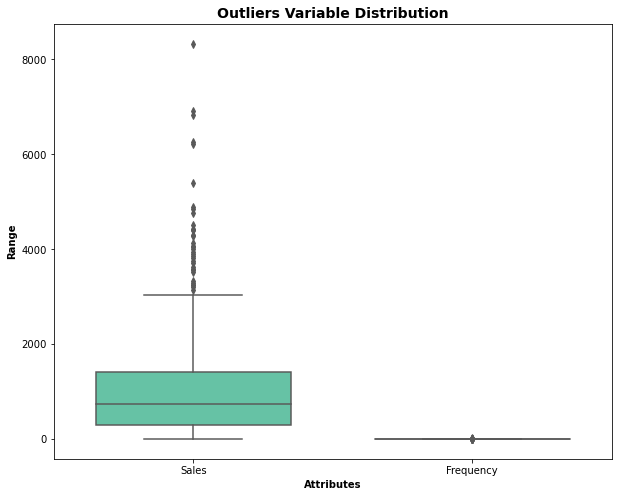

In [60]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Sales', 'Frequency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=funriture_final_df[attributes], orient="v",
            palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')


In [61]:
# Removing (statistical) outliers for Amount
Q1 = funriture_final_df.Sales.quantile(0.05)
Q3 = funriture_final_df.Sales.quantile(0.95)
IQR = Q3 - Q1
funriture_final_df = funriture_final_df[(funriture_final_df.Sales >= Q1 - 1.5*IQR) & (funriture_final_df.Sales <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = funriture_final_df.Frequency.quantile(0.05)
Q3 = funriture_final_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
funriture_final_df = funriture_final_df[(funriture_final_df.Frequency >= Q1 - 1.5*IQR) & (funriture_final_df.Frequency <= Q3 + 1.5*IQR)]


In [62]:
# Rescaling the attributes

funriture_final_df_for_clustering = funriture_final_df[['Sales', 'Frequency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled_f = scaler.fit_transform(funriture_final_df_for_clustering)
rfm_df_scaled_f.shape


(706, 2)

In [63]:
rfm_df_scaled_fu = pd.DataFrame(rfm_df_scaled_f)
rfm_df_scaled_fu.columns = ['Sales', 'Frequency']
rfm_df_scaled_fu.head()


,Sales,Frequency
0,-0.977261,-1.128542
1,-0.964061,-1.128542
2,-0.537821,-0.559434
3,2.586172,2.855211
4,-0.618537,-0.559434


In [64]:
# k-means with some arbitrary k

kmeans_2 = KMeans(n_clusters=3, max_iter=50)
kmeans_2.fit(rfm_df_scaled_fu)


KMeans(max_iter=50, n_clusters=3)

In [65]:
# assign the label
funriture_final_df['Cluster_Id'] = kmeans_2.labels_
funriture_final_df.head()


,Customer ID,Sales,Frequency,Cluster_Id
0,AA-10315,14.560,1,0
1,AA-10375,28.400,1,0
2,AA-10480,475.300,2,0
3,AA-10645,3750.713,8,2
4,AB-10015,390.672,2,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

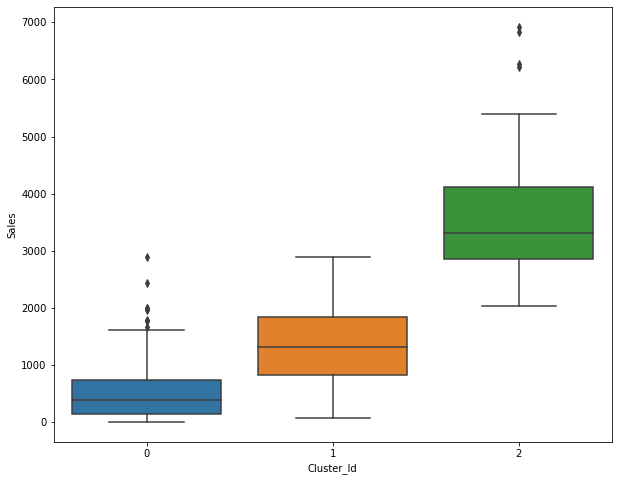

In [66]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Sales', data=funriture_final_df)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

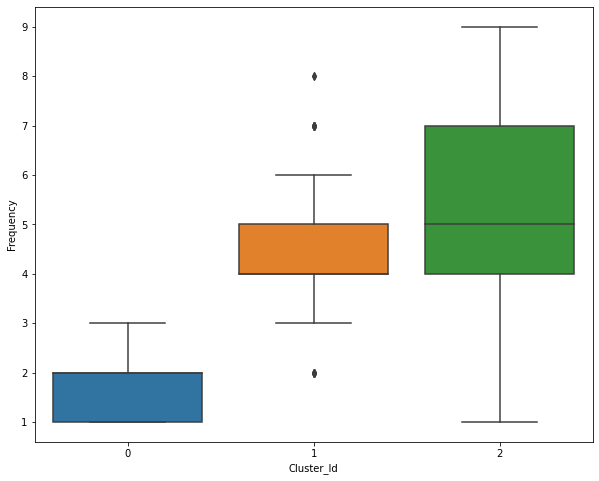

In [67]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=funriture_final_df)


## Office Supplies

In [68]:
office_supplies_df_monetary = office_supplies_df.groupby('Customer ID')['Sales'].sum()
office_supplies_df_monetary = office_supplies_df_monetary.reset_index()
office_supplies_df_monetary.head()


,Customer ID,Sales
0,AA-10315,5075.304
1,AA-10375,261.060
2,AA-10480,625.272
3,AA-10645,981.540
4,AB-10015,273.504


In [69]:
office_supplies_df_frequency = office_supplies_df.groupby('Customer ID')[
    'Order Date'].count()
office_supplies_df_frequency = office_supplies_df_frequency.reset_index()
office_supplies_df_frequency.columns = ['Customer ID', 'Frequency']
office_supplies_df_frequency.head()


,Customer ID,Frequency
0,AA-10315,8
1,AA-10375,11
2,AA-10480,8
3,AA-10645,8
4,AB-10015,3


In [70]:

office_supplies_final_df = pd.merge(office_supplies_df_monetary, office_supplies_df_frequency,
                              on='Customer ID', how='inner')
office_supplies_final_df.head()


,Customer ID,Sales,Frequency
0,AA-10315,5075.304,8
1,AA-10375,261.060,11
2,AA-10480,625.272,8
3,AA-10645,981.540,8
4,AB-10015,273.504,3


Text(0.5, 0, 'Attributes')

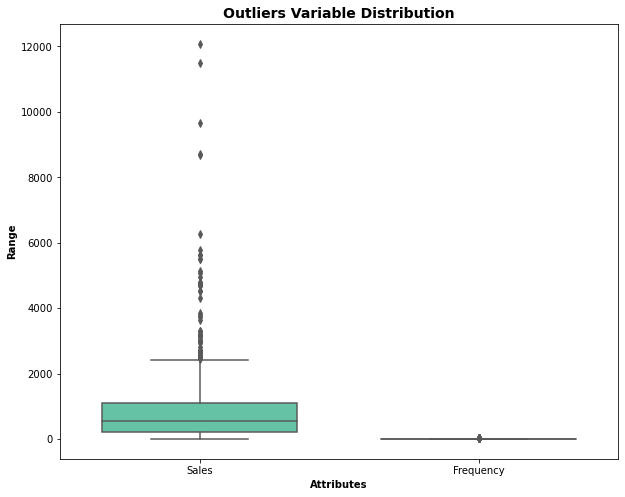

In [71]:
attributes = ['Sales', 'Frequency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=office_supplies_final_df[attributes], orient="v",
            palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')


In [72]:
# Removing (statistical) outliers for Amount
Q1 = office_supplies_final_df.Sales.quantile(0.05)
Q3 = office_supplies_final_df.Sales.quantile(0.95)
IQR = Q3 - Q1
office_supplies_final_df = office_supplies_final_df[(
    office_supplies_final_df.Sales >= Q1 - 1.5*IQR) & (office_supplies_final_df.Sales <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = office_supplies_final_df.Frequency.quantile(0.05)
Q3 = office_supplies_final_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
office_supplies_final_df = office_supplies_final_df[(
    office_supplies_final_df.Frequency >= Q1 - 1.5*IQR) & (office_supplies_final_df.Frequency <= Q3 + 1.5*IQR)]


In [73]:
# Rescaling the attributes

office_supplies_final_df_for_clustering = office_supplies_final_df[['Sales', 'Frequency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled_o = scaler.fit_transform(office_supplies_final_df_for_clustering)
rfm_df_scaled_o.shape


(783, 2)

In [74]:
rfm_df_scaled_of = pd.DataFrame(rfm_df_scaled_o)
rfm_df_scaled_of.columns = ['Sales', 'Frequency']
rfm_df_scaled_of.head()


,Sales,Frequency
0,4.417190,0.097842
1,-0.620069,0.836850
2,-0.238985,0.097842
3,0.133786,0.097842
4,-0.607049,-1.133837


In [75]:
# k-means with some arbitrary k

kmeans_3 = KMeans(n_clusters=3, max_iter=50)
kmeans_3.fit(rfm_df_scaled_of)


KMeans(max_iter=50, n_clusters=3)

In [76]:
# assign the label
office_supplies_final_df['Cluster_Id'] = kmeans_3.labels_
office_supplies_final_df.head()


,Customer ID,Sales,Frequency,Cluster_Id
0,AA-10315,5075.304,8,2
1,AA-10375,261.060,11,0
2,AA-10480,625.272,8,0
3,AA-10645,981.540,8,0
4,AB-10015,273.504,3,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

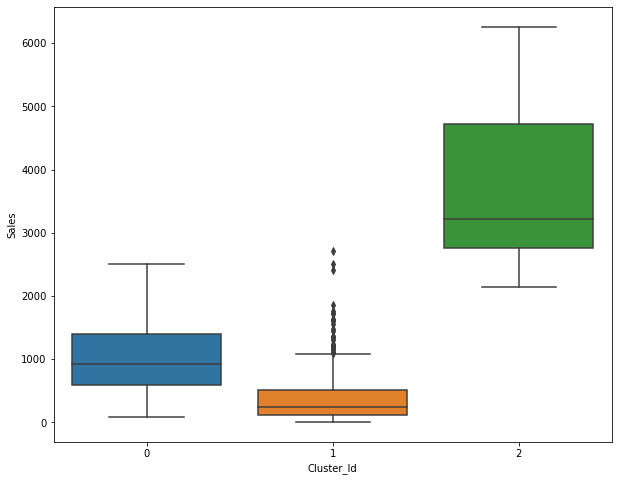

In [77]:
sns.boxplot(x='Cluster_Id', y='Sales', data=office_supplies_final_df)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

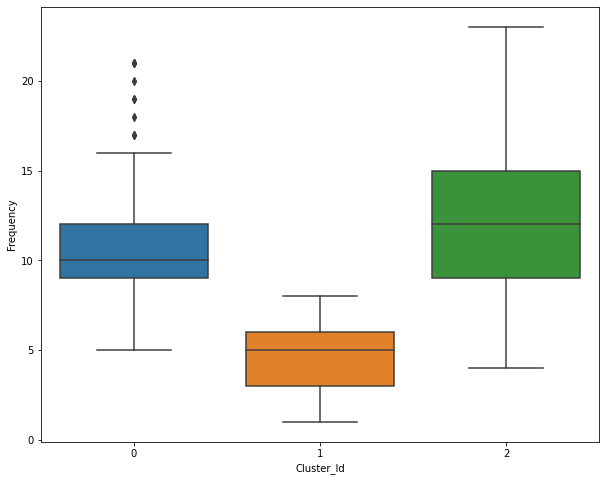

In [78]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=office_supplies_final_df)


## Technology

In [79]:
technology_df_monetary = technology_df.groupby('Customer ID')[
    'Sales'].sum()
technology_df_monetary = technology_df_monetary.reset_index()
technology_df_monetary.head()


,Customer ID,Sales
0,AA-10315,473.696
1,AA-10375,766.930
2,AA-10480,689.940
3,AA-10645,354.682
4,AB-10015,221.980


In [80]:
technology_df_frequency = technology_df.groupby('Customer ID')[
    'Order Date'].count()
technology_df_frequency = technology_df_frequency.reset_index()
technology_df_frequency.columns = ['Customer ID', 'Frequency']
technology_df_frequency.head()


,Customer ID,Frequency
0,AA-10315,2
1,AA-10375,3
2,AA-10480,2
3,AA-10645,2
4,AB-10015,1


In [81]:

technology_final_df = pd.merge(technology_df_monetary, technology_df_frequency,
                                    on='Customer ID', how='inner')
technology_final_df.head()


,Customer ID,Sales,Frequency
0,AA-10315,473.696,2
1,AA-10375,766.930,3
2,AA-10480,689.940,2
3,AA-10645,354.682,2
4,AB-10015,221.980,1


Text(0.5, 0, 'Attributes')

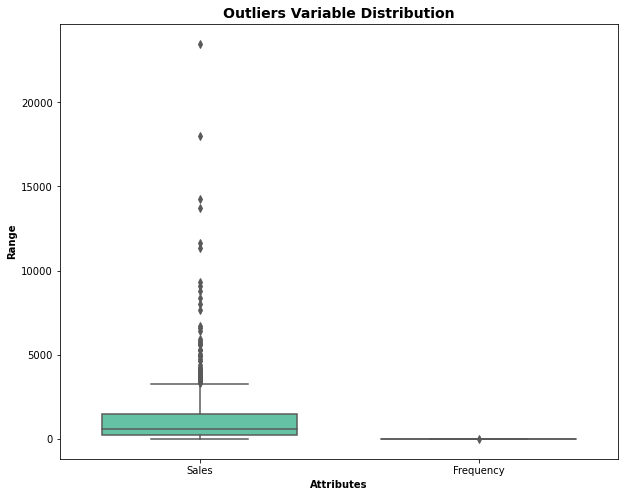

In [82]:
attributes = ['Sales', 'Frequency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=technology_final_df[attributes], orient="v",
            palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')


In [83]:
# Removing (statistical) outliers for Amount
Q1 = technology_final_df.Sales.quantile(0.05)
Q3 = technology_final_df.Sales.quantile(0.95)
IQR = Q3 - Q1
technology_final_df = technology_final_df[(
    technology_final_df.Sales >= Q1 - 1.5*IQR) & (technology_final_df.Sales <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = technology_final_df.Frequency.quantile(0.05)
Q3 = technology_final_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
technology_final_df = technology_final_df[(
    technology_final_df.Frequency >= Q1 - 1.5*IQR) & (technology_final_df.Frequency <= Q3 + 1.5*IQR)]


In [84]:
# Rescaling the attributes

technology_final_df_for_clustering = technology_final_df[[
    'Sales', 'Frequency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled_t = scaler.fit_transform(technology_final_df_for_clustering)
rfm_df_scaled_t.shape


(681, 2)

In [85]:
rfm_df_scaled_tech = pd.DataFrame(rfm_df_scaled_t)
rfm_df_scaled_tech.columns = ['Sales', 'Frequency']
rfm_df_scaled_tech.head()


,Sales,Frequency
0,-0.449876,-0.409335
1,-0.236562,0.188856
2,-0.292569,-0.409335
3,-0.536452,-0.409335
4,-0.632986,-1.007527


In [86]:
# k-means with some arbitrary k

kmeans_4 = KMeans(n_clusters=3, max_iter=50)
kmeans_4.fit(rfm_df_scaled_tech)


KMeans(max_iter=50, n_clusters=3)

In [87]:
# assign the label
technology_final_df['Cluster_Id'] = kmeans_4.labels_
technology_final_df.head()


,Customer ID,Sales,Frequency,Cluster_Id
0,AA-10315,473.696,2,0
1,AA-10375,766.930,3,0
2,AA-10480,689.940,2,0
3,AA-10645,354.682,2,0
4,AB-10015,221.980,1,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

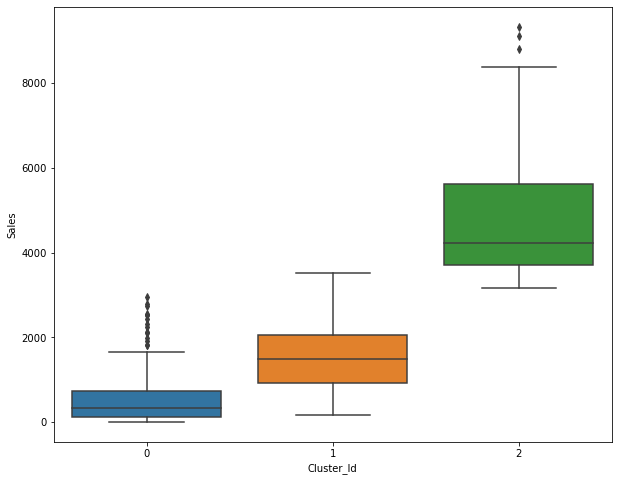

In [88]:
sns.boxplot(x='Cluster_Id', y='Sales', data=technology_final_df)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

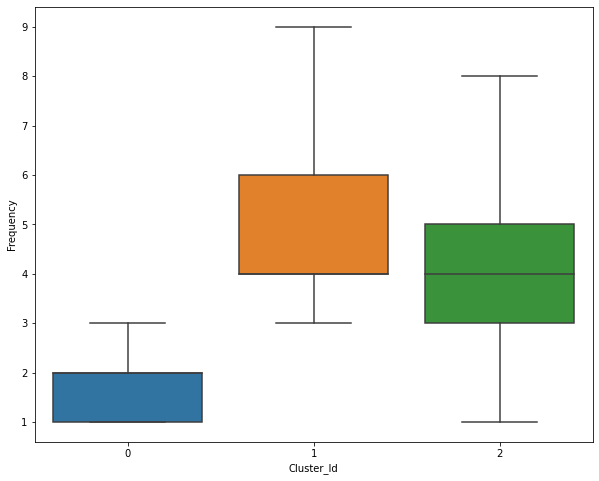

In [89]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=technology_final_df)


In [110]:

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style


In [113]:
final_df[["Amount", "Frequency", "Recency"]]

,Amount,Frequency,Recency
0,5563.560,11,184
1,1056.390,15,19
2,1790.512,12,259
3,5086.935,18,55
4,886.156,6,415
...,...,...,...
787,2374.658,28,43
788,5454.350,8,4
789,6720.444,12,9
790,8025.707,31,54


For n_clusters = 2 The average silhouette_score is : 0.6691549259685994
For n_clusters = 3 The average silhouette_score is : 0.5822809321849568
For n_clusters = 4 The average silhouette_score is : 0.5804247597040351
For n_clusters = 5 The average silhouette_score is : 0.5795445572432839
For n_clusters = 6 The average silhouette_score is : 0.5510659201959804


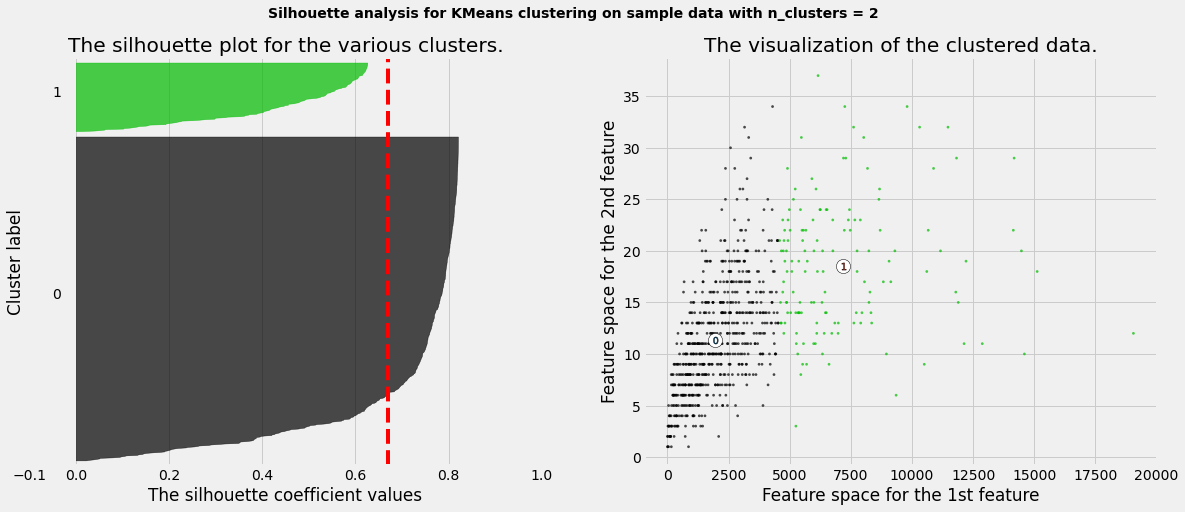

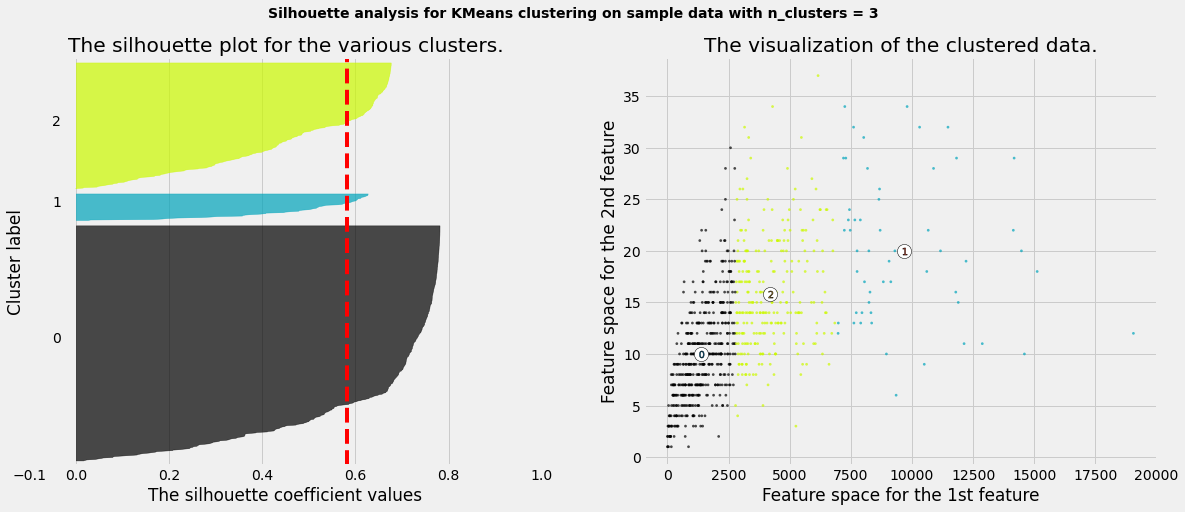

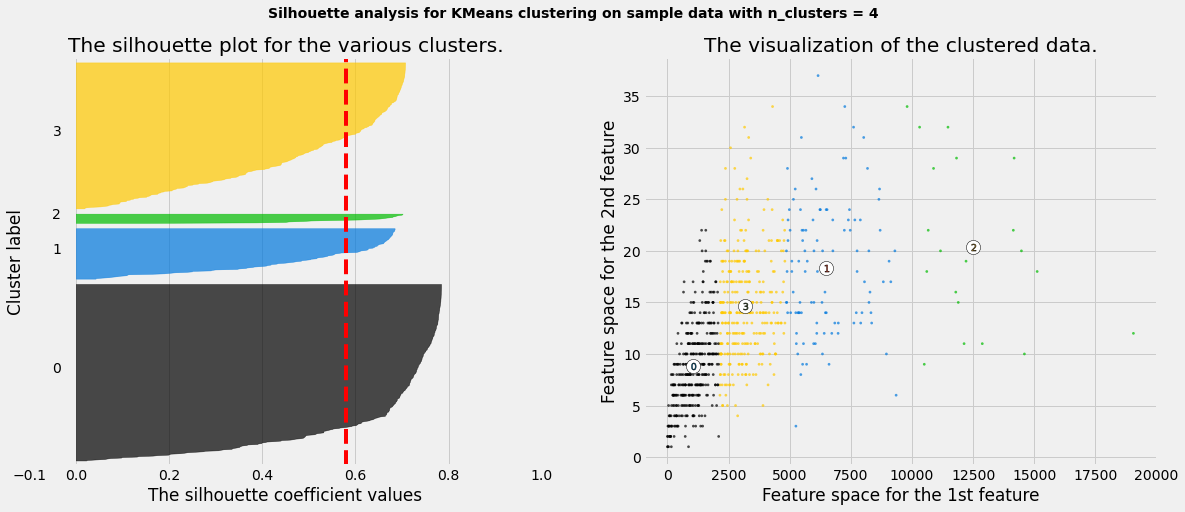

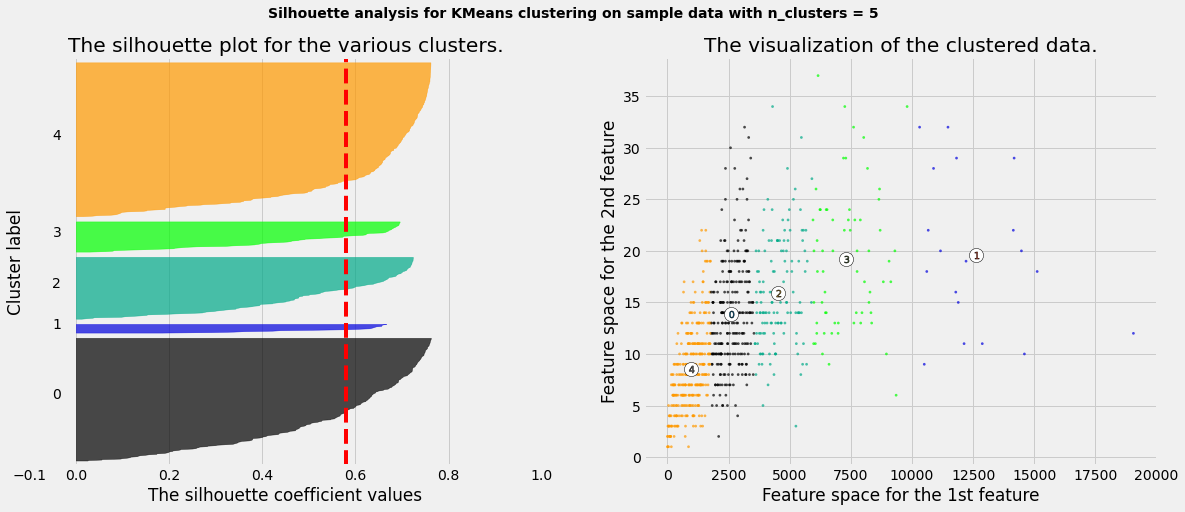

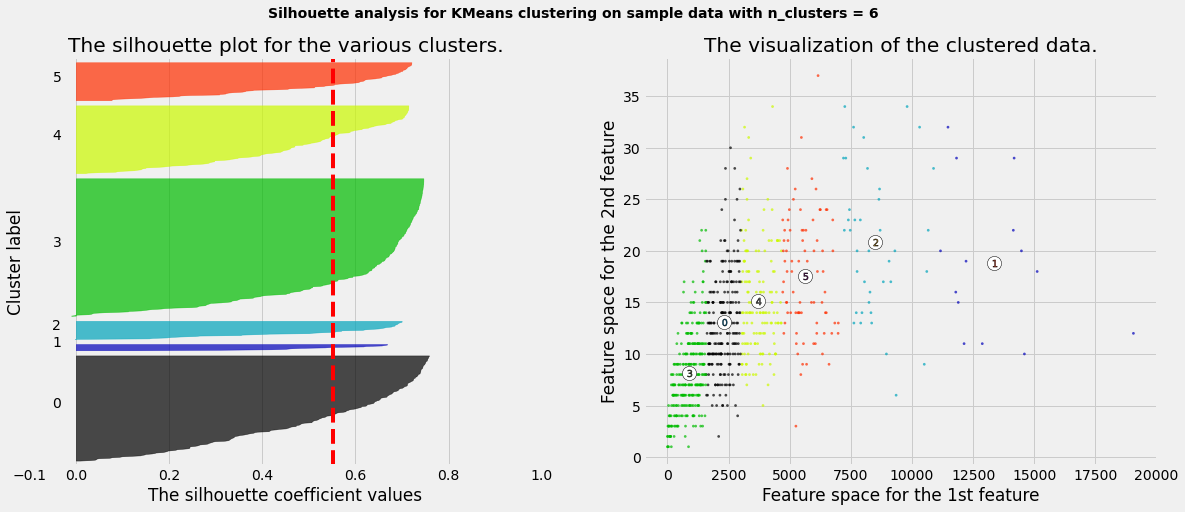

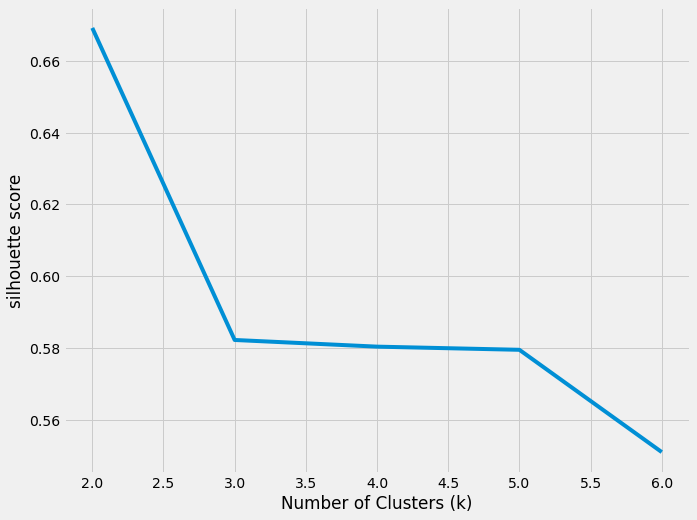

In [128]:
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(final_df[["Amount", "Frequency"]]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(final_df[["Amount", "Frequency"]])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(final_df[["Amount", "Frequency"]], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(final_df[["Amount", "Frequency"]], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(final_df[["Amount", "Frequency"]].iloc[:, 0], final_df[["Amount", "Frequency"]].iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()
